# Download Dataset

In [1]:
!pip install plyfile
!wget https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!unzip -qq shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip
# colab :
# !mkdir misc
# !printf  "airplane	0\nbathtub	1\nbed	2\nbench	3\nbookshelf	4\nbottle	5\nbowl	6\ncar	7\nchair	8\ncone	9\ncup	10\ncurtain	11\ndesk	12\ndoor	13\ndresser	14\nflower_pot	15\nglass_box	16\nguitar	17\nkeyboard	18\nlamp	19\nlaptop	20\nmantel	21\nmonitor	22\nnight_stand	23\nperson	24\npiano	25\nplant	26\nradio	27\nrange_hood	28\nsink	29\nsofa	30\nstairs	31\nstool	32\ntable	33\ntent	34\ntoilet	35\ntv_stand	36\nvase	37\nwardrobe	38\nxbox	39" > misc/modelnet_id.txt
# !printf "Airplane	4\nBag	2\nCap	2\nCar	4\nChair	4\nEarphone	3\nGuitar	3\nKnife	2\nLamp	4\nLaptop	2\nMotorbike	6\nMug	2\nPistol	3\nRocket	3\nSkateboard	3\nTable	3"  > misc/num_seg_classes.txt

--2023-05-24 15:42:50--  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 666265910 (635M) [application/zip]
Saving to: ‘shapenetcore_partanno_segmentation_benchmark_v0.zip’

tcore_partanno_segm   0%[                    ]   2.41M   555KB/s    eta 26m 54s^C
[shapenetcore_partanno_segmentation_benchmark_v0.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
note:  shapenetcore_partanno_segmentation_benchmark_v0.zip may be a plain executable, not an archive
unzip:  cannot find zipfi

# Install non-default deps

In [ ]:
!pip install wandb -qU
!pip install torch-summary

# Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F

import torch.utils.data as data
import os
import os.path
import sys
from tqdm import tqdm 
import json
from plyfile import PlyData, PlyElement

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: egurt. Use `wandb login --relogin` to force relogin


True

# Define Model


In [2]:


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STNkd(3)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat



def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

# Test model

In [3]:
def test_model():
  from torchsummary import summary
  sim_data = Variable(torch.rand(32,3,2500))
  # trans = STN3d()
  # out = trans(sim_data)
  # print('stn', out.size())
  # print('loss', feature_transform_regularizer(out))

  sim_data_64d = Variable(torch.rand(32, 64, 2500))
  trans = STNkd(k=64)
  out = trans(sim_data_64d)
  print('stn64d', out.size())
  print('loss', feature_transform_regularizer(out))

  pointfeat = PointNetfeat(global_feat=True)
  out, _, _ = pointfeat(sim_data)
  print('global feat', out.size())

  pointfeat = PointNetfeat(global_feat=False)
  out, _, _ = pointfeat(sim_data)
  print('point feat', out.size())

  cls = PointNetCls(k = 5, feature_transform=False)
  out, a, b = cls(sim_data)
  # print('class', out.size(), a.shape, b.shape)


  # seg = PointNetDenseCls(k = 3)
  # out, _, _ = seg(sim_data)
  # print('seg', out.size())
  summary(cls, sim_data)

test_model()

stn64d torch.Size([32, 64, 64])
loss tensor(129.1276, grad_fn=<MeanBackward0>)
global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
Layer (type:depth-idx)                   Output Shape              Param #
├─PointNetfeat: 1-1                      [-1, 1024]                --
|    └─STNkd: 2-1                        [-1, 3, 3]                --
|    |    └─Conv1d: 3-1                  [-1, 64, 2500]            256
|    |    └─BatchNorm1d: 3-2             [-1, 64, 2500]            128
|    |    └─Conv1d: 3-3                  [-1, 128, 2500]           8,320
|    |    └─BatchNorm1d: 3-4             [-1, 128, 2500]           256
|    |    └─Conv1d: 3-5                  [-1, 1024, 2500]          132,096
|    |    └─BatchNorm1d: 3-6             [-1, 1024, 2500]          2,048
|    |    └─Linear: 3-7                  [-1, 512]                 524,800
|    |    └─BatchNorm1d: 3-8             [-1, 512]                 1,024
|    |    └─Linear: 3-9                  [-1, 256

# Define Dataset

In [4]:
def get_segmentation_classes(root):
    catfile = os.path.join(root, 'synsetoffset2category.txt')
    cat = {}
    meta = {}

    with open(catfile, 'r') as f:
        for line in f:
            ls = line.strip().split()
            cat[ls[0]] = ls[1]

    for item in cat:
        dir_seg = os.path.join(root, cat[item], 'points_label')
        dir_point = os.path.join(root, cat[item], 'points')
        fns = sorted(os.listdir(dir_point))
        meta[item] = []
        for fn in fns:
            token = (os.path.splitext(os.path.basename(fn))[0])
            meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg')))
    
    with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../misc/num_seg_classes.txt'), 'w') as f:
        for item in cat:
            datapath = []
            num_seg_classes = 0
            for fn in meta[item]:
                datapath.append((item, fn[0], fn[1]))

            for i in tqdm(range(len(datapath))):
                l = len(np.unique(np.loadtxt(datapath[i][-1]).astype(np.uint8)))
                if l > num_seg_classes:
                    num_seg_classes = l

            print("category {} num segmentation classes {}".format(item, num_seg_classes))
            f.write("{}\t{}\n".format(item, num_seg_classes))

def gen_modelnet_id(root):
    classes = []
    with open(os.path.join(root, 'train.txt'), 'r') as f:
        for line in f:
            classes.append(line.strip().split('/')[0])
    classes = np.unique(classes)
    with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../misc/modelnet_id.txt'), 'w') as f:
        for i in range(len(classes)):
            f.write('{}\t{}\n'.format(classes[i], i))

class ShapeNetDataset(data.Dataset):
    def __init__(self,
                 root,
                 npoints=2500,
                 classification=False,
                 class_choice=None,
                 split='train',
                 data_augmentation=True):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.data_augmentation = data_augmentation
        self.classification = classification
        self.seg_classes = {}
        
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        if not class_choice is None:
            self.cat = {k: v for k, v in self.cat.items() if k in class_choice}

        self.id2cat = {v: k for k, v in self.cat.items()}

        self.meta = {}
        splitfile = os.path.join(self.root, 'train_test_split', 'shuffled_{}_file_list.json'.format(split))
        #from IPython import embed; embed()
        filelist = json.load(open(splitfile, 'r'))
        for item in self.cat:
            self.meta[item] = []

        for file in filelist:
            _, category, uuid = file.split('/')
            if category in self.cat.values():
                self.meta[self.id2cat[category]].append((os.path.join(self.root, category, 'points', uuid+'.pts'),
                                        os.path.join(self.root, category, 'points_label', uuid+'.seg')))

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        print(self.classes)
        with open( 'misc/num_seg_classes.txt', 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.seg_classes[ls[0]] = int(ls[1])
        self.num_seg_classes = self.seg_classes[list(self.cat.keys())[0]]
        print(self.seg_classes, self.num_seg_classes)

    def __getitem__(self, index):
        fn = self.datapath[index]
        cls = self.classes[self.datapath[index][0]]
        point_set = np.loadtxt(fn[1]).astype(np.float32)
        seg = np.loadtxt(fn[2]).astype(np.int64)
        #print(point_set.shape, seg.shape)

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        #resample
        point_set = point_set[choice, :]

        point_set = point_set - np.expand_dims(np.mean(point_set, axis = 0), 0) # center
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis = 1)),0)
        point_set = point_set / dist #scale

        if self.data_augmentation:
            theta = np.random.uniform(0,np.pi*2)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            point_set[:,[0,2]] = point_set[:,[0,2]].dot(rotation_matrix) # random rotation
            point_set += np.random.normal(0, 0.02, size=point_set.shape) # random jitter

        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))

        if self.classification:
            return point_set, cls
        else:
            return point_set, seg

    def __len__(self):
        return len(self.datapath)


# Experiments

## Load Dataset

In [5]:

data_path = 'shapenetcore_partanno_segmentation_benchmark_v0' 
points_n = 2500 
batch = 128 
dataset = ShapeNetDataset(
        root=data_path,
        classification=True,
        npoints=points_n)

test_dataset = ShapeNetDataset(
    root=data_path,
    classification=True,
    split='test',
    npoints=points_n,
    data_augmentation=False)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch,
    shuffle=True)

testdataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch,
        shuffle=True)

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
{'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
{'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4


## Create model

In [6]:
model = PointNetCls(len(dataset.classes)).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=20, gamma=0.5)
loss_func = F.nll_loss

## Train

In [13]:
wandb.init(project='point-net', config={
                                        'batch_size': batch,
                                        'points_n' : points_n}, name=f'{batch}_{points_n}')
from sklearn import metrics

for i in range(30):
  epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = [0]*4
  scheduler.step()
  for j, (points, target) in enumerate(dataloader):
    model.train()
    points = points.to(device)
    target = target.to(device)
    target = target[:, 0]
    points = points.transpose(2, 1)
    pred, trans, trans_feat = model(points)
    loss = loss_func(pred, target)
    optim.zero_grad()
    loss.backward()
    optim.step()
    # stdout log
    print(' '*60, end='\r')
    print(f'\r train {j} / {len(dataloader)}', end='', flush=True)
    # metrics
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(target.data).cpu().sum()
    epoch_train_acc += correct.item()/float(target.shape[0])
    epoch_train_loss += loss.item()
  prec = 0
  rec = 0
  # eval
  print()
  with torch.no_grad():
    for j, (points, target) in enumerate(testdataloader):
      target = target[:, 0]
      points = points.transpose(2, 1)
      points, target = points.cuda(), target.cuda()
      model = model.eval()
      pred, _, _ = model(points)
      loss = F.nll_loss(pred, target)
      # metrics 
      pred_choice = pred.data.max(1)[1]
      correct = pred_choice.eq(target.data).cpu().sum()
      acc = correct.item()/float(target.shape[0])
      epoch_test_acc += acc
      epoch_test_loss += loss.item()
      rec+= metrics.recall_score(target.cpu().numpy(), pred_choice.cpu().numpy(), labels=list(range(test_dataset.classes.__len__())),average=None, zero_division=0)
      prec += metrics.precision_score(target.cpu().numpy(), pred_choice.cpu().numpy(), labels=list(range(test_dataset.classes.__len__())), average=None, zero_division=0)
      # stdout log
      print(' '*60, end='\r')
      print(f'\r eval [{i}, {j} / {len(dataloader)}] loss {loss.item()}, acc {acc}', end='')
    rec/=len(testdataloader)
    prec/=len(testdataloader)
  epoch_train_loss /= len(dataloader)
  epoch_train_acc /= len(dataloader)
  epoch_test_loss /= len(testdataloader)
  epoch_test_acc /= len(testdataloader)
  print(f'\n mloss {epoch_train_loss} macc {epoch_train_acc}\n')
  print(rec)
  print(prec)
  wandb.log( {'acc_train' : epoch_train_acc, 
              'acc_test':epoch_test_acc,
              'loss_train' : epoch_train_loss, 
              'loss_test' : epoch_test_loss,
              'lr' : float(scheduler.get_lr()[0]), 
              })

acc_test,▁▃█▇█▃▇▇
acc_train,▁▁▁▁▁▁▁▁
loss_test,█▅▂▄▁▃▅▂
loss_train,▁▁▁▁▁▁▁▁
lr,▁███████
acc_test,0.93974
acc_train,0.0
loss_test,0.2036
loss_train,0.0
lr,0.0005


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 94 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/home/dan/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 train 18 / 95                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

KeyboardInterrupt: 

In [12]:
for i in dataset.classes:
    print(i, end=' ')

Airplane Bag Cap Car Chair Earphone Guitar Knife Lamp Laptop Motorbike Mug Pistol Rocket Skateboard Table 

[0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9375, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9375, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.921875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.9296875, 0.90625, 0.9140625, 0.90625, 0.7734375]


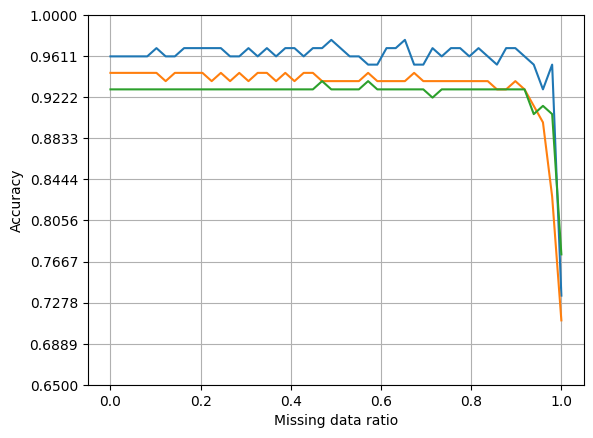

In [ ]:
from matplotlib import pyplot as plt
data_iter = iter(testdataloader)
exp_n = 50

for i in range(3):
    acc = []
    points, target = next(data_iter)
    target = target[:, 0]
    points = points.transpose(2, 1)
    target = target.to(device)
    points = points.to(device)
    
    for i in range(exp_n):
        with torch.no_grad():
            model.eval()
            shuffle = np.random.choice(np.arange(0, int(points.shape[-1])), int(int(points.shape[-1])*((exp_n-i)/exp_n)), replace=False)
            shufled_points = points[:,:, shuffle]
            pred, trans, trans_feat = model(shufled_points)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            acc.append(correct.item()/float(target.shape[0]))
            
    plt.plot( np.linspace(0, 1, exp_n), acc)
plt.xlabel('Missing data ratio')
plt.yticks(np.linspace(0.65, 1, 10))
plt.ylabel('Accuracy')
plt.grid(True)
print(acc)

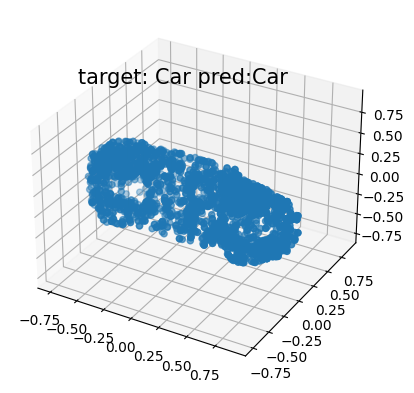

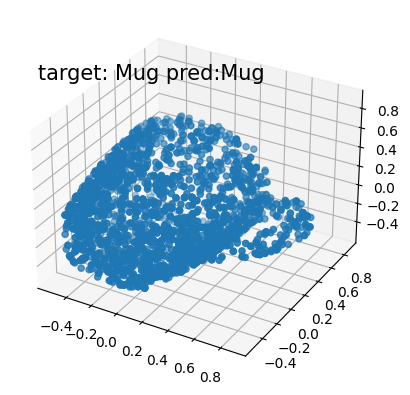

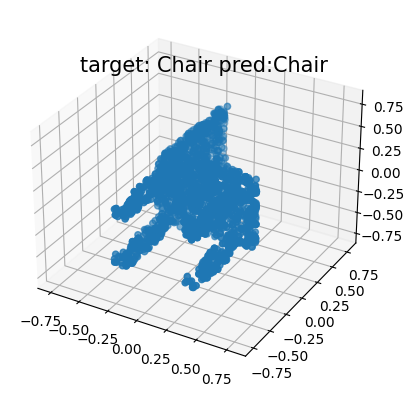

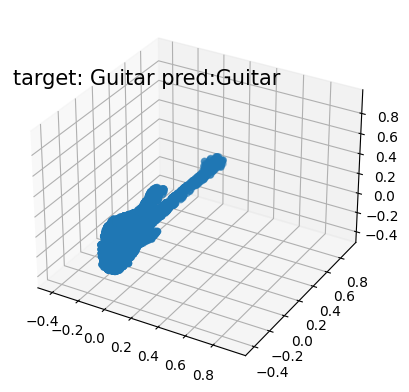

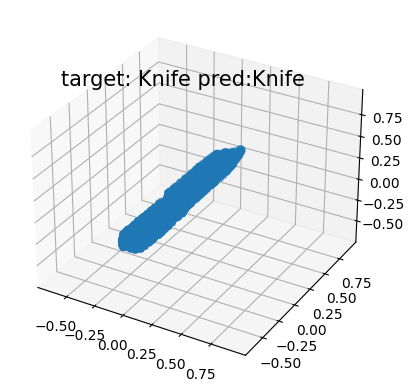

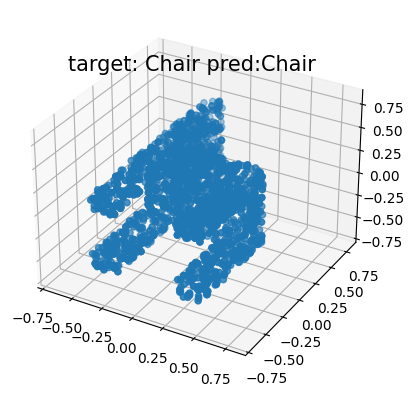

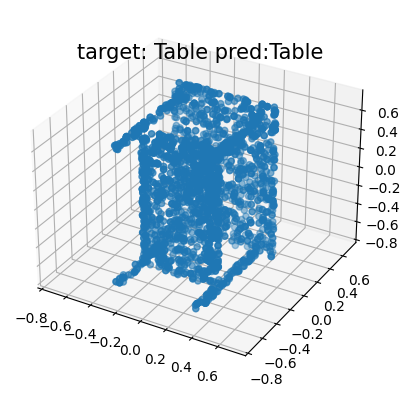

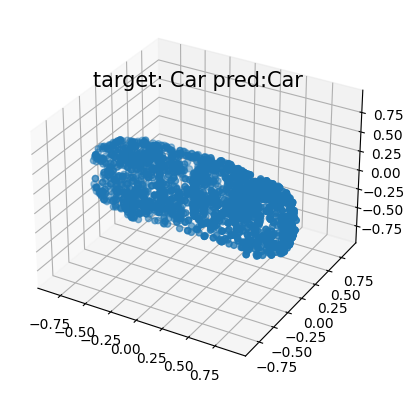

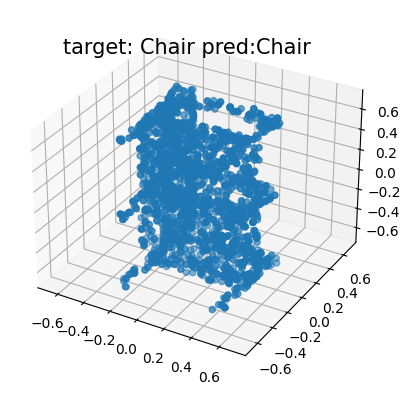

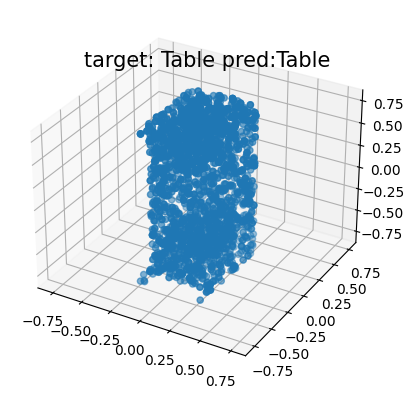

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
model.eval()
inv_classes = {test_dataset.classes[k] : k for k in test_dataset.classes}
def plot_result(i):
    with torch.no_grad():
      points,  gt_class = test_dataset[i]
      pred, _, _ = model(points.unsqueeze(0).transpose(2, 1).to(device))
      selected_class = pred.argmax()
      ax = plt.figure().add_subplot(projection='3d')
      min_cord = points.min()
      max_cord = points.max()
      ax.set_xlim(min_cord, max_cord)
      ax.set_ylim(min_cord, max_cord)
      ax.set_zlim(min_cord, max_cord)
      ax.text(-1, 0, 1, f'target: {inv_classes[gt_class.item()]} pred:{inv_classes[selected_class.item()]}', fontsize=15)
      ax.scatter(points[:, 0], points[:, 1], points[:, 2])
for i in np.random.randint(0, len(test_dataset), 10):
  plot_result(i)